In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os
import glob
import math
from scipy.optimize import curve_fit

In [22]:
# Define the hazard function calculator
def hazard_function_empirical_time(df):
    generation_times = np.asarray(df["generationtime"], dtype=float)
    generation_times = generation_times[np.isfinite(generation_times)]
    generation_times = np.sort(generation_times)
    min_diff = 0.001
    for i in range(len(generation_times) - 1):
        diff = generation_times[i + 1] - generation_times[i]
        if diff < min_diff and diff > 0:
            min_diff = diff
    N_t = len(generation_times)
    t_max = np.max(generation_times)
    grid = np.arange(0, t_max + min_diff, min_diff)
    survival = [(generation_times > t).sum()/N_t for t in grid]
    hazard = np.empty(len(grid)-1, dtype=float)
    for t in range(len(grid) - 1):
        hazard[t] = (-1/survival[t]) * (survival[t+1] - survival[t])/(grid[t+1] - grid[t])
    return grid, hazard/sum(hazard), survival[:-1]

def hazard_function_empirical_protein(df):
    protein_levels = np.asarray(df["protein_level"], dtype=float)
    protein_levels = protein_levels[np.isfinite(protein_levels)]
    protein_levels = np.sort(protein_levels)
    min_diff = 0.01
    N_t = len(protein_levels)
    p_max = np.max(protein_levels)
    grid = np.arange(0, p_max + min_diff, min_diff)
    survival = [(protein_levels > p).sum()/N_t for p in grid]
    hazard = np.empty(len(grid)-1, dtype=float)
    for p in range(len(grid) - 1):
        if survival[p] > 0 and survival[p+1] > 0:   #Checking division by zero
            hazard[p] = - (np.log(survival[p+1]) - np.log(survival[p])) / (grid[p+1] - grid[p])
        else:
            hazard[p] = 0
    return grid, hazard/sum(hazard), survival[:-1]


def protein_level(t, m0, alpha):
    return m0 * (np.exp(alpha * t) - 1)

In [ ]:
#Make a dictionary of dataframes
dfs = {}                                              
for path in glob.glob("data/*.csv"):
    if path=="data/UMIK_allSources.csv" or path=="data/df_UMIK_allSources.csv":
        continue
    name = os.path.splitext(os.path.basename(path))[0]  
    dfs[name] = pd.read_csv(path)

# Add protein levels to the dataframes
for name, df in dfs.items():
    df["protein_level"] = protein_level(df["generationtime"], df['length_birth'], df['growth_rate'])
# We used lenght instead of mass


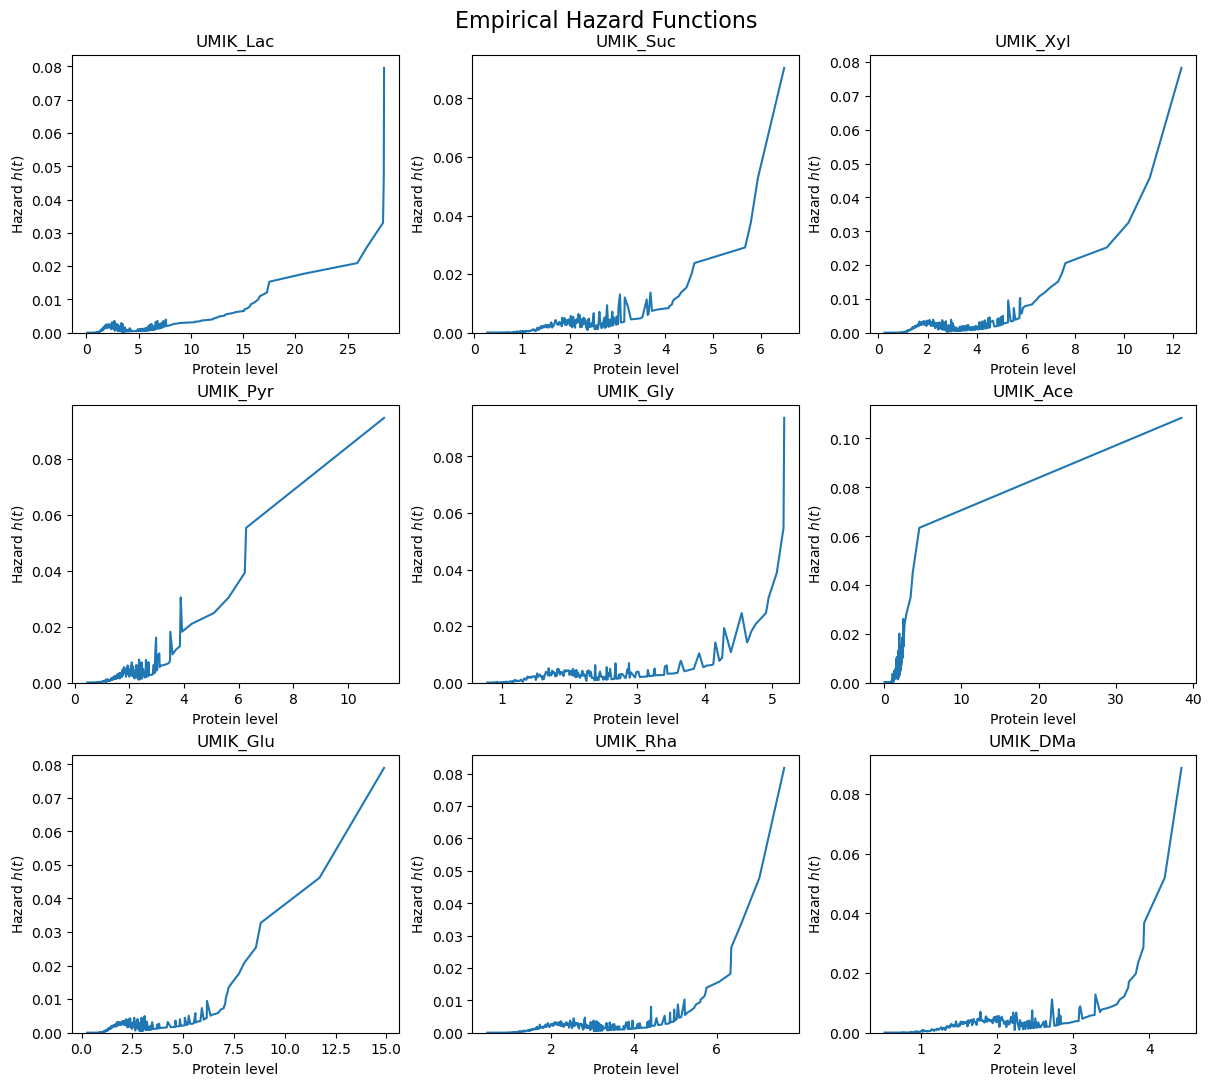

In [24]:
hazards = []                         
for name, df in dfs.items():         
    grid, h, survival = hazard_function_empirical_protein(df)
    mask = h > 0 #remove all the values where the hazard function is 0, is this the right thing to do?
    hazards.append((name, grid[:-1][mask], h[mask]))

n_plots = len(hazards)
n_cols   = 3
n_rows   = math.ceil(n_plots / n_cols)


fig, axes = plt.subplots(
    n_rows, n_cols,
    figsize=(4*n_cols, 3.5*n_rows),
    sharex=False, sharey=False,
    constrained_layout=True          
)

axes = axes.flatten()               

for ax, (name, grid, h) in zip(axes, hazards):

    """#remove extreme values
    if name == "UMIK_Ace":
        grid = grid[:-1]
        h = h[:-1]
        survival = survival[:-1]
    elif name == "UMIK_Pyr":
        grid = grid[:-1]
        h = h[:-1]
        survival = survival[:-1]"""

    ax.plot(grid, h, lw=1.5)
    ax.set_title(name)
    ax.set_xlabel("Protein level")
    ax.set_ylabel("Hazard $h(t)$")
    ax.set_ylim(bottom=0)

for ax in axes[n_plots:]:
    ax.set_visible(False)

plt.suptitle("Empirical Hazard Functions", fontsize=16, y=1.02)
plt.show()

In [25]:
def logistic_survival(t, a, b):
    return 1 / (1 + np.exp(a * (t - b)))

def generalized_logistic_survival(t, tau, k, alpha):
    return 1 / (1 + (t / tau)**k)**alpha

$ S(t) = \frac{1}{\left(1 + \left( \frac{t}{\tau} \right)^k \right)^{\alpha}}$

$t$: independent variable (e.g., protein level or time)

$\tau$: inflection point (location)

$k$: shape/steepness

$a$: scale or tail weight parameter

/var/folders/rq/k6q5m5x57ggcclsdrpv0g4j00000gn/T/ipykernel_10751/751255754.py:5: RuntimeWarning: invalid value encountered in power
  return 1 / (1 + (t / tau)**k)**alpha


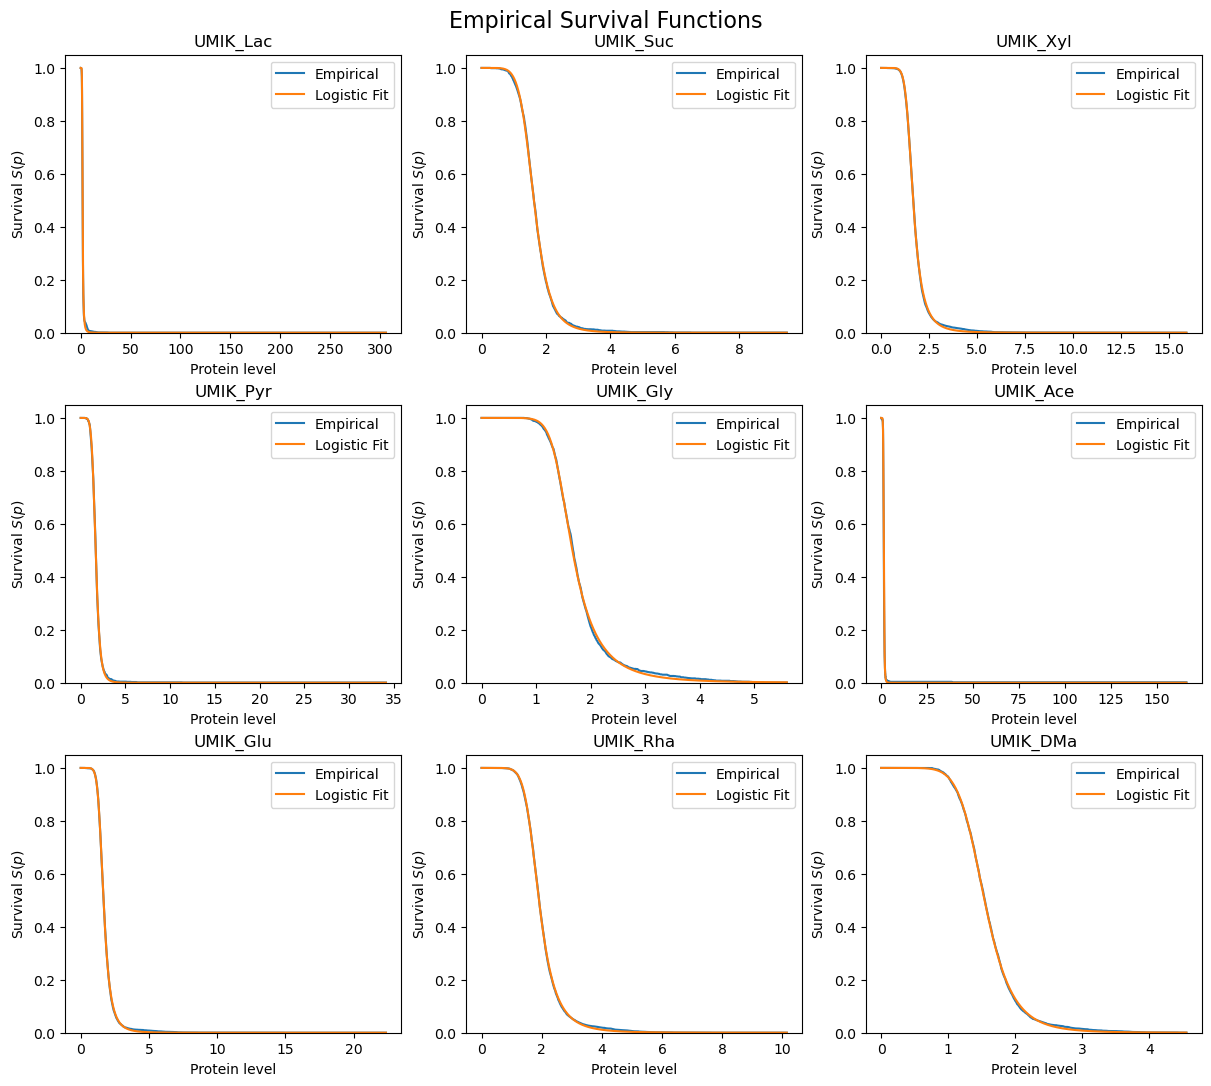

In [26]:
hazards = []                         

for name, df in dfs.items():         
    grid, h, survival = hazard_function_empirical_protein(df)
    hazards.append((name, grid[:-1], h, survival))

n_plots = len(hazards)
n_cols   = 3
n_rows   = math.ceil(n_plots / n_cols)


fig, axes = plt.subplots(
    n_rows, n_cols,
    figsize=(4*n_cols, 3.5*n_rows),
    sharex=False, sharey=False,
    constrained_layout=True          
)

axes = axes.flatten()               
fittingParams = []

for ax, (name, grid, h, survival) in zip(axes, hazards):

    popt, _ = curve_fit(generalized_logistic_survival, grid, survival, p0=[1, 1, 1])
    grid_fit = np.linspace(min(grid), max(grid), len(grid))
    survival_fit = generalized_logistic_survival(grid_fit, *popt)
    fittingParams.append(popt)
    
    ax.plot(grid, survival, lw=1.5, label='Empirical')
    ax.plot(grid_fit, survival_fit, label='Logistic Fit')

    ax.set_title(name)
    ax.set_xlabel("Protein level")
    ax.set_ylabel("Survival $S(p)$")
    ax.set_ylim(bottom=0)
    ax.legend()

for ax in axes[n_plots:]:
    ax.set_visible(False)

plt.suptitle("Empirical Survival Functions", fontsize=16, y=1.02)
plt.show()

fittingParams = pd.DataFrame(fittingParams)
fittingParams.columns = ["T", "k", "a"]

In [27]:
fittingParams

,T,k,a
0,1.597620,9.063562,0.402818
1,1.627688,6.695966,1.008939
2,1.503213,9.204902,0.543990
3,1.696184,6.879143,1.061840
4,1.486226,9.994281,0.487794
5,1.433339,8.987700,0.845285
6,1.545813,8.273218,0.643941
7,1.777104,8.197598,0.675169
8,1.520874,7.688450,0.926811


In [37]:
fittingParams['T'][0]

1.597619906823942

Text(0.5, 1.0, 'Fitting parameters')

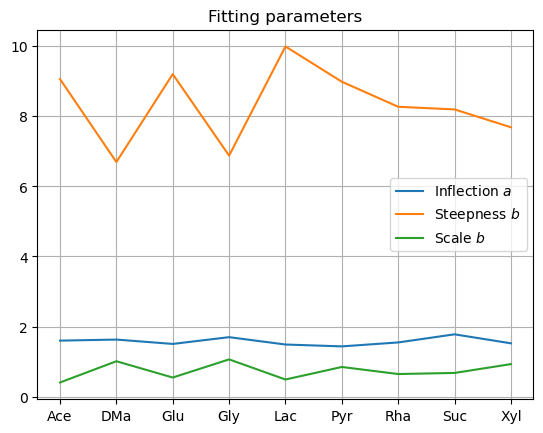

In [28]:
sugars = ["Ace", "DMa", "Glu", "Gly", "Lac", "Pyr", "Rha", "Suc", "Xyl"]

plt.plot(fittingParams["T"], label ='Inflection $a$')
plt.plot(fittingParams["k"], label ='Steepness $b$')
plt.plot(fittingParams["a"], label ='Scale $b$')

plt.legend()
plt.grid()
plt.xticks(ticks=[0,1,2,3,4,5,6,7,8], labels = sugars)
plt.title("Fitting parameters")

Text(0.5, 1.0, 'Scatter Plot of Fitting Parameters T - k')

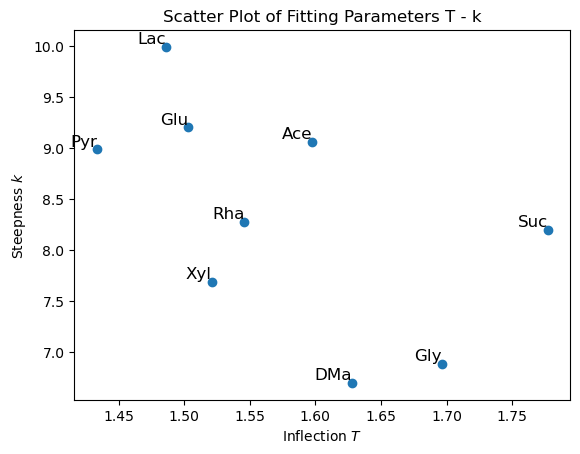

In [29]:
T = fittingParams["T"]
k = fittingParams["k"]
a = fittingParams["a"]

plt.scatter(T,k)
for i, label in enumerate(sugars):
    plt.text(T[i], k[i], label, fontsize=12, ha='right', va='bottom')
plt.xlabel('Inflection $T$')
plt.ylabel('Steepness $k$')
plt.title('Scatter Plot of Fitting Parameters T - k')

# Hazard function from survial fit (DMa)

In [30]:
grid = hazards[1][1]
h = hazards[1][2]
survival = hazards[1][3]

In [31]:
popt, _ = curve_fit(generalized_logistic_survival, grid, survival, p0=[1, 1, 1])
grid_fit = np.linspace(min(grid), max(grid), len(grid))
survival_fit = generalized_logistic_survival(grid_fit, *popt)

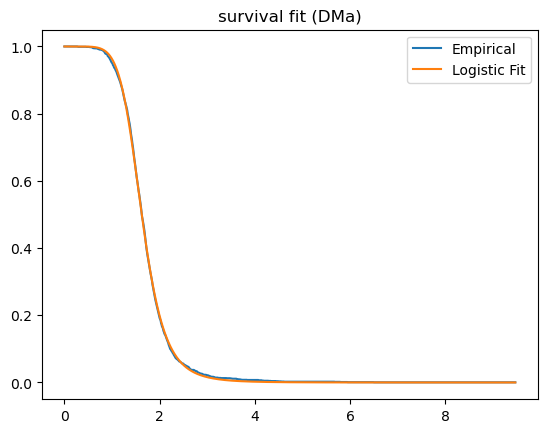

In [32]:
plt.plot(grid, survival, lw=1.5, label='Empirical')
plt.plot(grid_fit, survival_fit, label='Logistic Fit')
plt.title("survival fit (DMa)")
plt.legend()

In [33]:
hazard = np.empty(len(grid)-1, dtype=float)
for p in range(len(grid) - 1):
    if survival_fit[p] > 0 and survival_fit[p+1] > 0:
        hazard[p] = - (np.log(survival_fit[p+1]) - np.log(survival_fit[p])) / (grid_fit[p+1] - grid_fit[p])
    else:
        hazard[p] = 0

Text(0.5, 1.0, 'hazard from survival fit (DMa)')

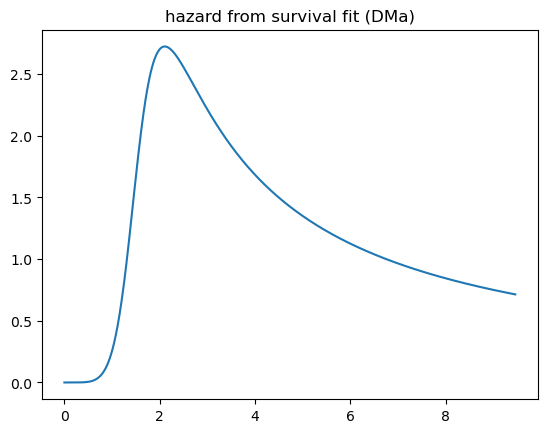

In [34]:
plt.plot(grid_fit[:-1],hazard)
plt.title("hazard from survival fit (DMa)")

In [38]:
def division_time_pdf(t, alpha, k, tau):
    # Compute the probability density function (PDF) of the division time
    return (alpha * k/tau) * (t/tau)**(k-1) * (1+ (t/tau)**k)**(-1-alpha)


Acceptance rate: 0.502


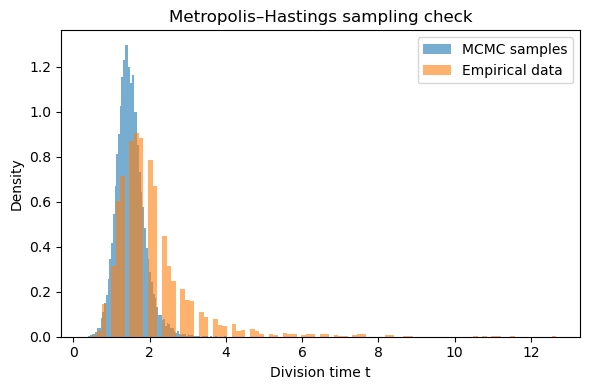

In [55]:
# --- Parameters that we got from the fit ------------------------------------
alpha = fittingParams['a'][8]   # shape/“heaviness” of the tail
k     = fittingParams['k'][8]   # shape/“peakedness”
tau   = fittingParams['T'][8]   # scale (same units as t)

# --- Metropolis–Hastings sampler -----------------------------------
n_samples = 50_000
burn_in   = 5_000        # discarded warm‑up iterations
step_size = 0.45         # std‑dev of the proposal on log‑scale

samples   = np.zeros(n_samples, dtype=float)
log_t_cur = np.log(tau)  # sensible starting guess

rng = np.random.default_rng()

accept_cnt = 0
for i in range(n_samples):
    # propose on log‑scale so t > 0 automatically
    log_t_prop = log_t_cur + rng.normal(0.0, step_size)
    t_cur, t_prop = np.exp(log_t_cur), np.exp(log_t_prop)

    # Metropolis acceptance ratio (proposal symmetric in log‑space)
    log_acc_ratio = np.log(division_time_pdf(t_prop, alpha, k, tau)) - \
                    np.log(division_time_pdf(t_cur,  alpha, k, tau))
    if np.log(rng.random()) < log_acc_ratio:
        log_t_cur = log_t_prop   # accept
        accept_cnt += 1

    samples[i] = np.exp(log_t_cur)

accept_rate = accept_cnt / n_samples
print(f"Acceptance rate: {accept_rate:.3f}")

# --- Diagnostics & visual check ------------------------------------
posterior_samples = samples[burn_in:]
empirical_time = dfs["UMIK_DMa"]["generationtime"]
plt.figure(figsize=(6, 4))
plt.hist(posterior_samples, bins=100, density=True, alpha=0.6, label="MCMC samples", color='C0')
plt.hist(empirical_time, bins=100, density=True, alpha=0.6, label="Empirical data", color='C1')

plt.xlabel("Division time t")
plt.ylabel("Density")
plt.title("Metropolis–Hastings sampling check")
plt.legend()
plt.tight_layout()

Acceptance rate: 0.632


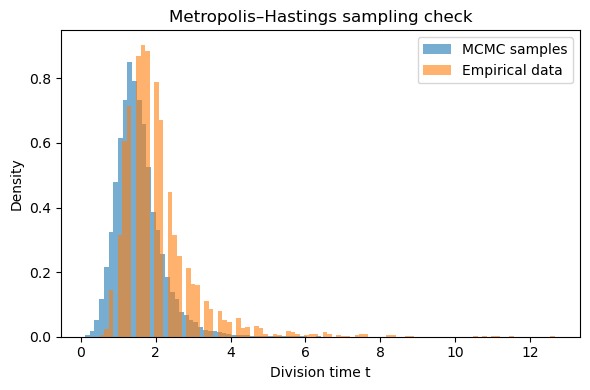

In [72]:
# --- Parameters that we played with------------------------------------
alpha = 0.80  # shape/“heaviness” of the tail
k     = 5.1   # shape/“peakedness”
tau   = 1.55  # scale (same units as t)

# --- Metropolis–Hastings sampler -----------------------------------
n_samples = 50_000
burn_in   = 5_000        # discarded warm‑up iterations
step_size = 0.45         # std‑dev of the proposal on log‑scale

samples   = np.zeros(n_samples, dtype=float)
log_t_cur = np.log(tau)  # sensible starting guess

rng = np.random.default_rng()

accept_cnt = 0
for i in range(n_samples):
    # propose on log‑scale so t > 0 automatically
    log_t_prop = log_t_cur + rng.normal(0.0, step_size)
    t_cur, t_prop = np.exp(log_t_cur), np.exp(log_t_prop)

    # Metropolis acceptance ratio (proposal symmetric in log‑space)
    log_acc_ratio = np.log(division_time_pdf(t_prop, alpha, k, tau)) - \
                    np.log(division_time_pdf(t_cur,  alpha, k, tau))
    if np.log(rng.random()) < log_acc_ratio:
        log_t_cur = log_t_prop   # accept
        accept_cnt += 1

    samples[i] = np.exp(log_t_cur)

accept_rate = accept_cnt / n_samples
print(f"Acceptance rate: {accept_rate:.3f}")

# --- Diagnostics & visual check ------------------------------------
posterior_samples = samples[burn_in:]
empirical_time = dfs["UMIK_DMa"]["generationtime"]
plt.figure(figsize=(6, 4))
plt.hist(posterior_samples, bins=100, density=True, alpha=0.6, label="MCMC samples", color='C0')
plt.hist(empirical_time, bins=100, density=True, alpha=0.6, label="Empirical data", color='C1')

plt.xlabel("Division time t")
plt.ylabel("Density")
plt.title("Metropolis–Hastings sampling check")
plt.legend()
plt.tight_layout()

### Superimposing the empirical calculation with the fit